# House Prices Prediction with Principal Component Analysis (PCA )
Filzahanti Nuha Ramadhani

- There are 14 attributes in the dataset: crim, zn, indus, chas, nox, rm, age, dis, rad, tax, ptratio, black, lstat, and mdev.<br>
- Attribute information from the UCI Machine Learning Repository:
    1. CRIM (per capita crime rate by town)
    2. ZN (proportion of residential land zoned for lots over 25,000 sq.ft.)
    3. INDUS (proportion of non-retail business acres per town)
    4. CHAS (Charles River dummy variable (= 1 if tract bounds river 0 otherwise)
    5. NOX (nitric oxides concentration (parts per 10 million)
    6. RM (average number of rooms per dwelling)
    7. AGE (proportion of owner-occupied units built prior to 1940)
    8. DIS (weighted distances to five Boston employment centres)
    9. RAD (index of accessibility to radial highways)
    10. TAX (full-value property-tax rate per \$10,000)
    11. PTRATIO (pupil-teacher ratio by town)
    12. Black (1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town)
    13. LSTAT (\% lower status of the population)
    14. MEDV (Median value of owner-occupied homes in $1000's)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [2]:
dataset = load_boston()
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['MEDV'] = dataset.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Data Preprocessing

Check each column's type.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


Check if there are missing values.    

In [4]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Check if there are duplicated rows.

In [5]:
df.duplicated().sum()

0

Split target variable from other features.

In [6]:
X = df.drop('MEDV', axis=1)
y = df['MEDV']

Split train and test sets. <br>
We split data into train and test sets before applying PCA to avoid data leakage.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

Standardize the data.

In [8]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

## PCA

### Calculate covariance matrix

In [9]:
xtrain = X_train_std.copy()

In [10]:
cov_matrix = np.cov(X_train_std.T)
cov_matrix

array([[ 1.0026455 , -0.20852513,  0.42555506, -0.05723741,  0.45492641,
        -0.27599943,  0.37951239, -0.39858735,  0.64929845,  0.60305392,
         0.29810061, -0.4026666 ,  0.51139762],
       [-0.20852513,  1.0026455 , -0.52543114, -0.02323535, -0.51660473,
         0.32099398, -0.58551614,  0.64188401, -0.31314678, -0.31231928,
        -0.39990964,  0.17392516, -0.42181263],
       [ 0.42555506, -0.52543114,  1.0026455 ,  0.02480732,  0.75698333,
        -0.40055913,  0.63469337, -0.69991855,  0.60051395,  0.72946187,
         0.41471174, -0.34817513,  0.60584131],
       [-0.05723741, -0.02323535,  0.02480732,  1.0026455 ,  0.030768  ,
         0.12502719,  0.05545196, -0.06706826,  0.00819382, -0.04566313,
        -0.07730413,  0.05189225, -0.07133542],
       [ 0.45492641, -0.51660473,  0.75698333,  0.030768  ,  1.0026455 ,
        -0.29446177,  0.73710238, -0.7698765 ,  0.63564142,  0.68683196,
         0.22192659, -0.37722844,  0.58157539],
       [-0.27599943,  0.320993

### Eigendecomposition of covariance matrix

In [11]:
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)
print('eigenvalues:\n', eigen_values, '\neigen vectors:\n', eigen_vectors)

eigenvalues:
 [6.16953904 1.3654163  1.25692997 0.91966421 0.84639008 0.67655275
 0.51650872 0.371627   0.06359242 0.2750049  0.16968284 0.17988884
 0.22359446] 
eigen vectors:
 [[-0.26399673  0.342026   -0.18868868 -0.02622164 -0.17494252 -0.15856205
   0.72983315  0.15962353 -0.05023149 -0.3405648  -0.08778383 -0.18985901
   0.02983315]
 [ 0.25466606  0.36929014 -0.27688177 -0.071288   -0.23787209 -0.36005257
  -0.2569814  -0.51545459  0.08123974 -0.29307244 -0.00088565  0.15424761
  -0.28772587]
 [-0.34511225 -0.09519113  0.01668449  0.03895285  0.03551525 -0.09123942
  -0.42045585  0.05825007  0.26028701 -0.5819283   0.14820138 -0.26383333
   0.42698569]
 [ 0.00699884 -0.4067504  -0.33818346  0.60311283 -0.58709512  0.09548694
   0.00405866  0.00987095 -0.04558834  0.0063964  -0.01122859 -0.00117513
  -0.01526358]
 [-0.34420822 -0.19293241 -0.12766617 -0.18231499  0.01079902 -0.17909471
  -0.20606641  0.03724601 -0.03302417  0.08522766 -0.79859934 -0.14833149
  -0.22494606]
 [ 0.19

### Determine the components

In [12]:
explained_variance = []
for i in eigen_values:
    explained_variance.append(i/sum(eigen_values)*100)
print(explained_variance)

[47.33277366371466, 10.475489369664638, 9.643181053001355, 7.055674295725346, 6.493514297889661, 5.190520395665764, 3.962660763437747, 2.8511265537932164, 0.4878817429163162, 2.1098406914273173, 1.3018086689202053, 1.3801092620105644, 1.7154192418332208]


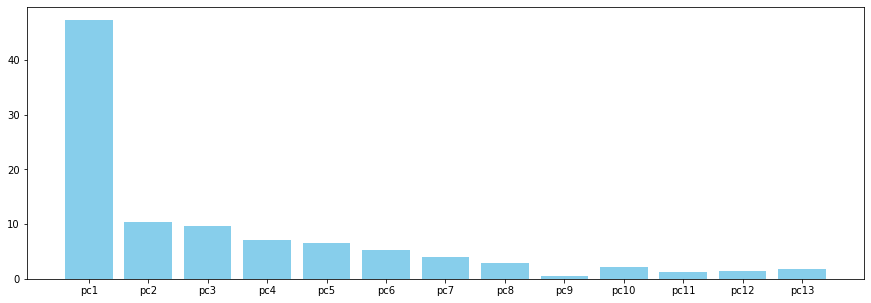

In [13]:
plt.figure(figsize=(15,5))
plt.bar(['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8','pc9','pc10','pc11','pc12','pc13'], explained_variance, color='skyblue')
plt.show()

In [14]:
cumulative_explained_variance = np.cumsum(explained_variance)
print(cumulative_explained_variance)

[ 47.33277366  57.80826303  67.45144409  74.50711838  81.00063268
  86.19115308  90.15381384  93.00494039  93.49282214  95.60266283
  96.9044715   98.28458076 100.        ]


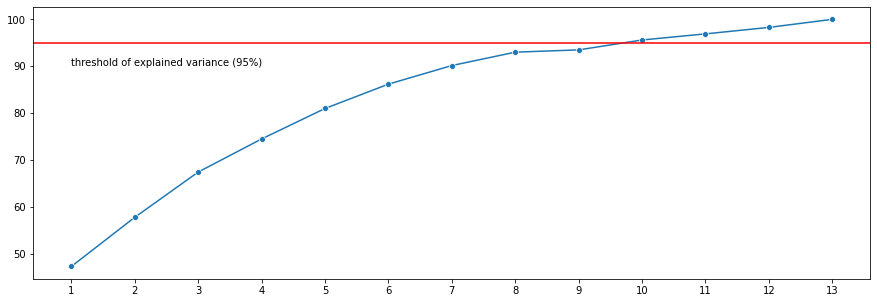

In [15]:
plt.figure(figsize=(15,5))
#visualize the cumulative explained variance
ax = sns.lineplot(x=np.arange(1,14,1), y=cumulative_explained_variance, marker='o')
ax.set_xticks(np.arange(1,14,1))
plt.axhline(y=95, color='red',linestyle='-')
plt.text(1, 90, 'threshold of explained variance (95%)')
plt.show()

Use the first 9 principal components as they captured 95% of variance.

In [16]:
projection_matrix = (eigen_vectors.T[:][:9]).T
print(projection_matrix)

[[-0.26399673  0.342026   -0.18868868 -0.02622164 -0.17494252 -0.15856205
   0.72983315  0.15962353 -0.05023149]
 [ 0.25466606  0.36929014 -0.27688177 -0.071288   -0.23787209 -0.36005257
  -0.2569814  -0.51545459  0.08123974]
 [-0.34511225 -0.09519113  0.01668449  0.03895285  0.03551525 -0.09123942
  -0.42045585  0.05825007  0.26028701]
 [ 0.00699884 -0.4067504  -0.33818346  0.60311283 -0.58709512  0.09548694
   0.00405866  0.00987095 -0.04558834]
 [-0.34420822 -0.19293241 -0.12766617 -0.18231499  0.01079902 -0.17909471
  -0.20606641  0.03724601 -0.03302417]
 [ 0.1914657  -0.16695673 -0.60993925 -0.05185236  0.43003889  0.1412069
   0.1601548  -0.29909804 -0.05312216]
 [-0.31296634 -0.34203719  0.01551473 -0.16055834  0.0424599  -0.04697381
   0.19170669 -0.55634289  0.04642157]
 [ 0.31985167  0.36504905  0.06894231  0.14770983 -0.13783526  0.02031623
  -0.10618881 -0.08039191  0.03406815]
 [-0.31828859  0.26272613 -0.31019885  0.20592935  0.13715226 -0.14405553
  -0.03497694  0.137500

In [17]:
#Get the product of eigenvectors and standardized X_train
X_train_pca = X_train_std.dot(projection_matrix)
#Get the product of eigenvectors and standardized X_test
X_test_pca = X_test_std.dot(projection_matrix)

## Modeling

### LightGBM without PCA

In [18]:
lgbm = LGBMRegressor(random_state=100)
param_lgbm = {'n_estimators': [30, 50, 100, 200],
             'boosting_type':['gbdt','dart','goss','rf']}
lgbm_search = GridSearchCV(lgbm, param_grid=param_lgbm, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)
lgbm_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=100), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
                         'n_estimators': [30, 50, 100, 200]},
             scoring='neg_root_mean_squared_error')

In [19]:
lgbm_search.best_params_

{'boosting_type': 'gbdt', 'n_estimators': 200}

In [20]:
lgbm_pred = lgbm_search.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, lgbm_pred))

### LightGBM with PCA

In [21]:
lgbm = LGBMRegressor(random_state=100)
param_lgbm = {'n_estimators': [30, 50, 100, 200],
             'boosting_type':['gbdt','dart','goss','rf']}
lgbm_search = GridSearchCV(lgbm, param_grid=param_lgbm, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)
lgbm_search.fit(X_train_pca, y_train)

GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=100), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
                         'n_estimators': [30, 50, 100, 200]},
             scoring='neg_root_mean_squared_error')

In [22]:
lgbm_search.best_params_

{'boosting_type': 'gbdt', 'n_estimators': 200}

In [23]:
lgbm_pred_pca = lgbm_search.predict(X_test_pca)
rmse_pca = np.sqrt(mean_squared_error(y_test, lgbm_pred_pca))

### Evaluation

In [24]:
df_rmse = pd.DataFrame([rmse, rmse_pca], columns=['rmse'], index=['without PCA', 'with PCA'])

In [26]:
df_rmse

,rmse
without PCA,3.757534
with PCA,4.680964


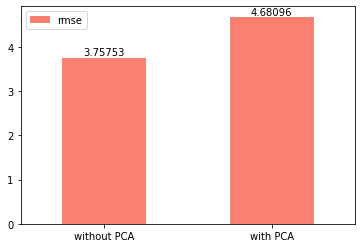

In [37]:
ax = df_rmse.plot(kind='bar', rot=0, color='salmon')
for i in ax.containers:
    ax.bar_label(i)

- LightGBM without PCA gave better result than with PCA because the root mean squared error is smaller at 3.757534 than with PCA at 4.680964.